# Análise dos Dados de Treino

A primeira etapa a ser feito durante o projeto é a __Análise dos Dados__. Como nesta avaliação, os dados de treino e teste já estão separados, iremos considerar que o teste é os dados com o modelo já em produção. __Sendo assim, apenas o melhor modelo treinado será utilizado no conjunto de teste, para não ter nenhum vazamento de informação.__

## Pacotes e inicializações importantes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy import stats

%matplotlib inline
sns.set()

# usado para o valor float do Pandas ficar neste formato
pd.options.display.float_format = '{:,.2f}'.format

# Tamanho da Figura ao imprimir os gráficos
rcParams['figure.figsize'] = 15, 10

## Leitura dos dados de treino

In [2]:
train_path = '../data/raw/treino.csv'

df = pd.read_csv(train_path, sep=',')
df.head()

,inadimplente,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,1,0.77,45,2,0.80,"9,120.00",13,0,6,0,2.00
1,0,0.96,40,0,0.12,"2,600.00",4,0,0,0,1.00
2,0,0.66,38,1,0.09,"3,042.00",2,1,0,0,0.00
3,0,0.23,30,0,0.04,"3,300.00",5,0,0,0,0.00
4,0,0.91,49,1,0.02,"63,588.00",7,0,1,0,0.00


# Análise Inicial

Antes de fazer uma análise a fundo das variáveis, será feito uma análise inicial que dará as seguintes informações:

* Formato do `DataFrame` (Quantidade de Linhas, Quantidade de Colunas)
* Distribuição da variável **inadimplente** (estamos trabalhando com um conjunto de dados balanceado?)
* Os tipos de cada uma das variáveis

## Tamanho dos Dados

Antes de tudo, podemos verificar o tamanho do `DataFrame` para se ter uma noção da quantidade de dados que serão utilizados

In [3]:
df.shape

(110000, 11)

## Distribuição dos dados `inadimplente`

Outro ponto importante que é bom avaliar prematuramente é a distribuição dos dados, para verificar se o dataset é balanceado ou não.

In [4]:
# organiza os dados em formato de DataFrame
info = pd.DataFrame(df['inadimplente'].value_counts())
info.columns = ['quantidade']
info['porcentagem'] = info['quantidade'] / info['quantidade'].sum()
info.index = ['Não Inadimplente', 'Inadimplente']

info

,quantidade,porcentagem
Não Inadimplente,102669,0.93
Inadimplente,7331,0.07


Além da visualização em formato `DataFrame`, é possível apresentar a informação em um gráfico de pizza, para termos uma noção de proporção dos dados.

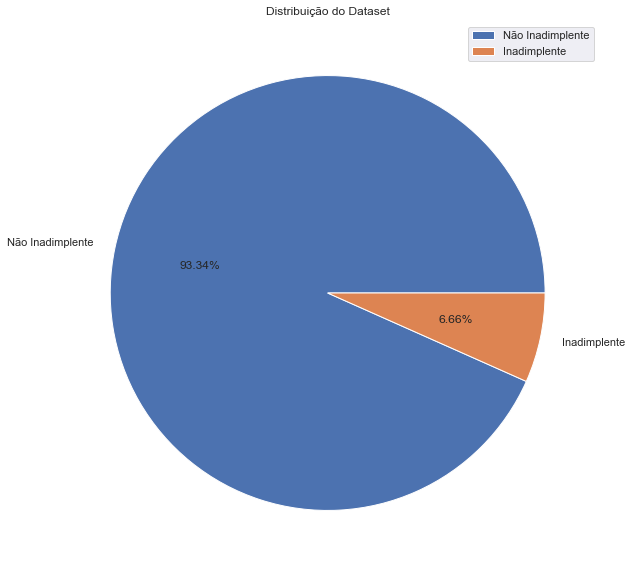

In [5]:
info.plot.pie(y='quantidade', autopct="%.2f%%")

plt.title('Distribuição do Dataset')
plt.ylabel('')
plt.show()

Neste caso, a distribuição da variável **inadimplente** é de 93/7, onde 93% dos dados **NÃO SÃO** inadimplentes e 7% **SÃO** inadimplentes. Isto é algo para se tomar cuidado, pois em um modelo que apenas respondesse como **NÃO INADIMPLENTE** teria uma acurácia de 93%, o que parece bom como um resultado sem nenhum contexto, mas se tratando de um modelo que não é capaz de fazer nada. 

## Tipos das variáveis

E por fim, verificamos os tipos de cada uma das variáveis do `DataFrame` através do método **dtypes**

In [6]:
df.dtypes

inadimplente                               int64
util_linhas_inseguras                    float64
idade                                      int64
vezes_passou_de_30_59_dias                 int64
razao_debito                             float64
salario_mensal                           float64
numero_linhas_crdto_aberto                 int64
numero_vezes_passou_90_dias                int64
numero_emprestimos_imobiliarios            int64
numero_de_vezes_que_passou_60_89_dias      int64
numero_de_dependentes                    float64
dtype: object

Todas as variáveis do dataset são númericas, o que já é um trabalho a menos pois não teremos que trabalhar com transformações necessárias em variáveis categóricas.

Com as informações adquiridas, podemos passar para uma análise mais afundo de cada uma das variáveis.

# Análisando cada uma das variáveis

Nesta seção será feito uma análise mais afundo de cada uma das variáveis, onde será verificado sua distribuição, se existe valores *outliers* e se seu comportamento é muito diferente no caso de ser **inadimplente ou não**.

No arquivo **README.md** do projeto é feito uma descrição de cada uma das variáveis. Esta informação será apresentada aqui para ter um melhor entendimento de cada uma delas (removendo a variável **inadimplente**)

| Váriavel 	| Descrição 	|
|:-	|:-	|
| idade | *A idade do cliente* |
| numero_de_dependentes | *O número de pessoas dependentes do cliente* |
| salario_mensal | *Salário mensal do cliente* |
| numero_emprestimos_imobiliarios | *Quantidade de empréstimos imobiliários que o cliente possui em aberto* |
| numero_vezes_passou_90_dias | *Número de vezes que o tomador passou mais de 90 dias em atraso* |
| util_linhas_inseguras | *Quanto que o cliente está usando, relativamente ao limite dele, de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc* |
| vezes_passou_de_30_59_dias | *Número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo* |
| razao_debito | *Razão entre as dívidas e o patrimônio do tomador. razão débito = Dividas/Patrimônio* |
| numero_linhas_crdto_aberto | *Número de empréstimos em aberto pelo cliente* |
| numero_de_vezes_que_passou_60_89_dias | *Número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo* |

**Para uma melhor organização, a análise será feita na mesma ordem da tabela.**

## Variável: `idade`

A variável idade é auto explicatória, pois indica a idade do cliente.

### Valores `NaNs`

Uma das primeiras verificações a ser feita ao avaliar uma coluna é procurar a presença de valores **NaNs** (ou nulos)

In [7]:
def verifica_nans(column):
    
    # Quantidade de NaNs
    total = df[column].isna().sum()
    true_qt = df.query('inadimplente == 1')[column].isna().sum()
    false_qt = total - true_qt
    
    # Porcentagem de NaNs no conjunto
    total_per = total / df.shape[0]
    true_per = true_qt / df.query('inadimplente == 1').shape[0]
    false_per = false_qt / df.query('inadimplente == 0').shape[0]
    
    print('Verificando a coluna', column)
    print('Quantidade de valores nulos: {} [{:.2f}%]'.format(
        total, total_per * 100))
    print('Quantidade de valores nulos (inadimplente): {} [{:.2f}%]'.format(
        true_qt, true_per * 100))
    print('Quantidade de valores nulos (não inadimplente): {} [{:.2f}%]'.format(
        false_qt, false_per * 100))

In [8]:
verifica_nans('idade')

Verificando a coluna idade
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


No caso da variável **idade**, não existe nenhum registro de valores nulos.

### Distribuição

A primeira etapa de verificar a variável, é apresentar sua distribuição. Felizmente, o **Pandas** possuí um método `describe` que já ajuda bastante neste processo, pois apresenta informações sobre a média, desvio padrão, valor mínimo, primeiro quartil, mediana, terceiro quartil e valor máximo.

In [9]:
df['idade'].describe()

count   110,000.00
mean         52.26
std          14.77
min           0.00
25%          41.00
50%          52.00
75%          63.00
max         109.00
Name: idade, dtype: float64

Além disso, utilizando o método `groupby` do **Pandas**, é possível agrupar os dados pelos valores de uma variável. Neste caso, utilizando a coluna **inadimplente**, é possível visualizar a distribuição da idade para os dados de inadimplentes e não inadimplentes.

In [10]:
df.groupby('inadimplente')['idade'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",52.71,14.78,0.00,42.00,52.00,63.00,109.00
1,"7,331.00",45.94,13.00,21.00,36.00,45.00,54.00,99.00


Em conjunto com a visualização das distribuições, podemos verificar os dados através do seu histograma. Onde cada valor encontrado é quantificado para visualizar como é sua distribuição. Como os dados são bastante desbalanceados, será verificado a porcentagem de cada valor ao conjunto total ao inves da sua quantidade exata.

**neste exemplo, será usado 110 bins, pois teremos um "bin" (classe) para cada uma das idades (0 até 109, com o 0 incluído)**

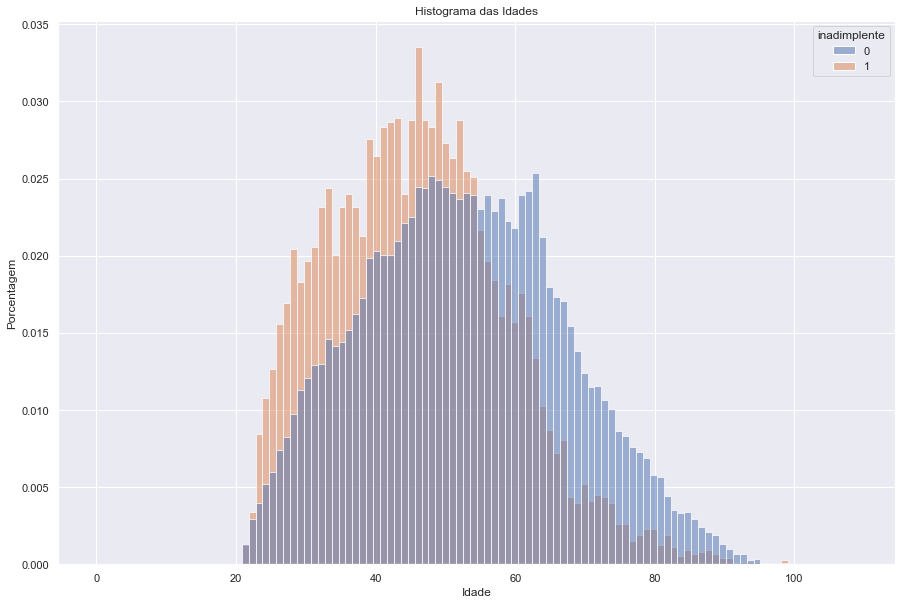

In [11]:
sns.histplot(data=df, x='idade', hue='inadimplente', bins=110, 
             stat='probability', common_norm=False)

plt.title('Histograma das Idades')
plt.xlabel('Idade')
plt.ylabel('Porcentagem')
plt.show()

Através da observação do gráfico, é possível verificar que a distribuição da idade nos **inadimplentes** está mais a esquerda, significando que em idades menores, a possibilidade de ser **inadimplente** é maior. Mesmo assim, essa diferença não é tão grande, em um modelo de *Machine Learning*, está informação pode ser utilizada mas não parece ser a melhor indicação.

### *Outliers*

Um dado é chamado de **outlier** quando ele possuí um valor muito diferente da distribuição em si. Como a frase "muito diferente" pode indicar muitas coisas, existe algumas técnicas para encontrar tais valores. As mais utilizadas são as seguintes:

* *Z-Score* - Verifica a distância do valor pra média, utilizando o desvio padrão. Em outras palavras, quantos "desvio padrão" o valor está da média. Em técnicas para eliminar outliers, normalmente é retirado valores que possuem um *Z-Score* maior que 3.
* Distância Interquartilica - Neste método, é utilizado a distância interquartilica (IQR) para eliminar valores *outliers* do conjunto de dados. A IQR é calculado através do intervalo entre o Q3 e Q1. Para ver se um valor é outlier, é utilizado a fórmula: $Q1 - 1.5 * IQR$ para valores menores que o Q1 e $Q3 + 1.5 * IQR$ para valores maiores que o Q3.

O Método da distância interquartilica é utilizado para verificar *outliers* em um gráfico de caixa. No nosso caso iremos utilizar o *Z-Score* para eliminar os outliers mas faremos a visualização através do gráfico de caixa.

In [12]:
outliers = df[(np.abs(stats.zscore(df['idade'])) > 3)]

print('Quantidade de outliers (Z-Score):', outliers.shape[0])

Quantidade de outliers (Z-Score): 36


E agora podemos visualizar os dados representados por um gráfico de caixa.

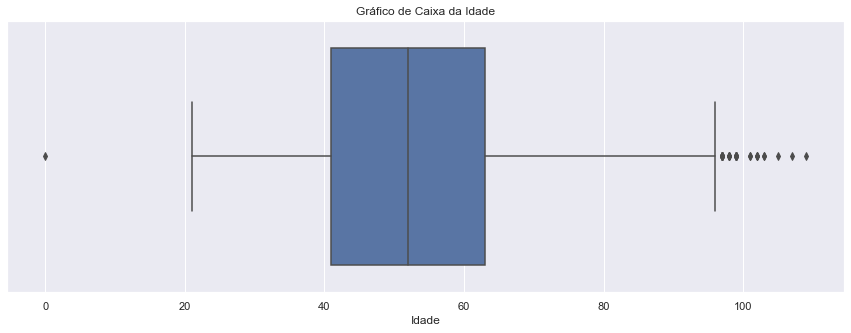

In [13]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='idade')

plt.title('Gráfico de Caixa da Idade')
plt.xlabel('Idade')
plt.show()

Os pontos fora dos limites dos "bigodes" do gráfico são os valores outliers. Podemos pegar a quantidade exata através da formula matemática.

In [14]:
def outliers_iqr(column):
    df_notna = df.dropna(subset=[column])
    
    
    q1 = df_notna[column].quantile(.25)
    q3 = df_notna[column].quantile(.75)
    iqr = q3 - q1

    down_limit = q1 - 1.5 * iqr
    up_limit = q3 + 1.5 * iqr
    
    outliers = df_notna[
        (df_notna[column] > up_limit) | (df_notna[column] < down_limit)
    ]
    print('Quantidade de Outliers (IQR):', outliers.shape[0])

In [15]:
outliers_iqr('idade')

Quantidade de Outliers (IQR): 36


## Variável: `numero_de_dependentes`

Esta variável indica a quantidade de depentes que o cliente possuí.

> OBS: Como já foi explicado os tópicos, as próximas análises não focará na explicação e sim no comportamento e *insights* encontrados da variável

### Valores `NaNs`

In [16]:
verifica_nans('numero_de_dependentes')

Verificando a coluna numero_de_dependentes
Quantidade de valores nulos: 2878 [2.62%]
Quantidade de valores nulos (inadimplente): 132 [1.80%]
Quantidade de valores nulos (não inadimplente): 2746 [2.67%]


Nesta coluna, já começamos a encontrar valores nulos. Isto pode ser um problema, dependendo da quantidade encontrada. Existe diversas maneiras de contornar tais problemas, mas será testado essas maneiras em outro Notebook.

### Distribuição

In [17]:
df['numero_de_dependentes'].describe()

count   107,122.00
mean          0.76
std           1.11
min           0.00
25%           0.00
50%           0.00
75%           1.00
max          20.00
Name: numero_de_dependentes, dtype: float64

Esta distribuição já é bem diferente da anterior, pois não possui um comportamento próximo da distribuição normal. Pelo menos, metade dos dados é totalmente zerado, e próximo de $1/4$ dos dados possui pelo menos 1 depedente. Veremos como é o comportamento se analisar separadamente em **inadimplente** e **não inadimplente**.

In [18]:
df.groupby('inadimplente')['numero_de_dependentes'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"99,923.00",0.74,1.11,0.00,0.00,0.00,1.00,20.00
1,"7,199.00",0.94,1.21,0.00,0.00,0.00,2.00,8.00


O comportamento dos dados são bem parecidos, apenas mudando que $1/4$ dos inadimplentes possuem pelo menos 2 dependentes. Com tais resultados, podemos visualizar qual a distribuição dos dados entre $75\% - 100\%$, para ver se existe muitos valores a cima de 2 dependentes.

In [19]:
q3 = df['numero_de_dependentes'].quantile(.75)

check_df = df[df['numero_de_dependentes'] > q3]
check_df['numero_de_dependentes'].describe()

count   24,054.00
mean         2.57
std          0.83
min          2.00
25%          2.00
50%          2.00
75%          3.00
max         20.00
Name: numero_de_dependentes, dtype: float64

Como pode ser visto, na parte "superior" dos dados, a maioria se encontra entre 2 e 3 dependentes, e o de valor 20 deve ser uma rara exceção. Só para ter certeza, vamos contabilizar tais valores.

In [20]:
df['numero_de_dependentes'].value_counts()

0.00     63652
1.00     19416
2.00     14306
3.00      6898
4.00      2111
5.00       563
6.00       115
7.00        38
8.00        16
10.00        4
9.00         2
20.00        1
Name: numero_de_dependentes, dtype: int64

Quantidades acima de 4 depedentes ficam escassas. Uma possível técnica para contornar tais problemas é agrupar valores em uma classe, como: "5 ou mais dependentes".

Agora, veremos a visualização dos dados através do histograma.

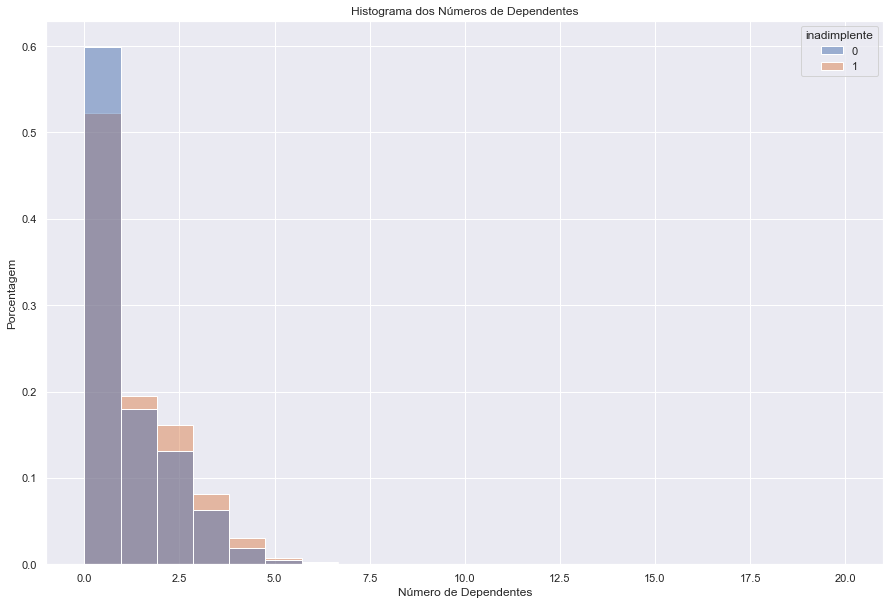

In [21]:
sns.histplot(data=df, x='numero_de_dependentes', hue='inadimplente', bins=21,
             stat='probability', common_norm=False)

plt.title('Histograma dos Números de Dependentes')
plt.xlabel('Número de Dependentes')
plt.ylabel('Porcentagem')
plt.show()

### *Outliers*

Como visto pela distribuição através do método `describe`, a média do "dependentes" é menor que $1$ (0.76) e o desvio padrão é um pouco maior que $1$ (1.11), dependendo da técnica utilizada, 4 dependentes já será considerado um outlier.

Sendo assim, veremos a quantidade de outliers usando as técnicas apresentadas anteriormente.

**Lembrando: o Z-Score é indicado em uma distribuição próxima da normal, e como a maioria dos dados estão inseridos na esquerda, não parece ser a melhor maneira de trabalhar com tais dados**

**Lembrando (2): Esta coluna possui dados nulos, então, para verificar os outliers, teremos que retira-los da coluna**

In [22]:
df_notna = df.dropna(subset=['numero_de_dependentes'])
outliers = df_notna[(np.abs(stats.zscore(df_notna['numero_de_dependentes'])) > 3)]

print('Quantidade de outliers (Z-Score):', outliers.shape[0])

Quantidade de outliers (Z-Score): 739


Neste caso, $739$ valores foram considerados outliers. Veremos quais valores são estes:

In [23]:
outliers['numero_de_dependentes'].value_counts()

5.00     563
6.00     115
7.00      38
8.00      16
10.00      4
9.00       2
20.00      1
Name: numero_de_dependentes, dtype: int64

pelos valores, apenas 4 ou menos depedentes ficaram no dataset, o que neste caso seria uma grande perda. Em uma ultima verificação, veremos como esses outliers estão distribuidos entre **inadimplentes** e **não inadimplentes**.

In [24]:
outliers['inadimplente'].value_counts()

0    666
1     73
Name: inadimplente, dtype: int64

A grande maioria se encontra em **não inadimplentes**, MAS como os dados de **inadimplentes** são tão escassos, não seria uma boa ficar sem tais dados.

Por último, podemos visualizar o gráfico de caixa deste conjunto para ver como os outliers ficam encontrados.

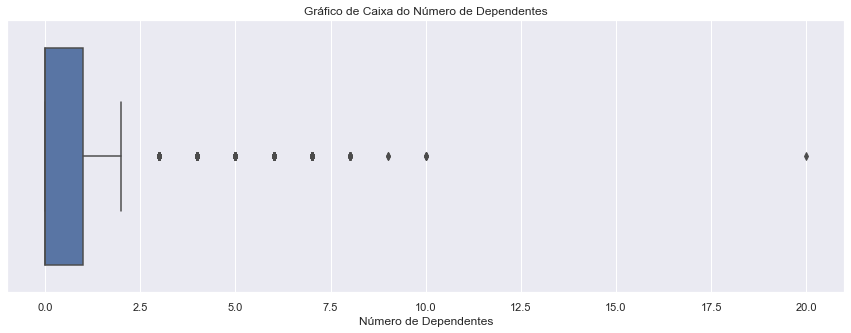

In [25]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='numero_de_dependentes')

plt.title('Gráfico de Caixa do Número de Dependentes')
plt.xlabel('Número de Dependentes')
plt.show()

Parece bem próximo do que foi visto usando o *Z-Score*, então, veremos a quantidade de outliers com essa técnica.

In [26]:
outliers_iqr('numero_de_dependentes')

Quantidade de Outliers (IQR): 9748


É, neste caso, a quantidade de outliers é MUITO maior, pois pela fórmula de $Q3 + 1.5 * IQR$ e com $\{Q3 = 1.0 ; IQR = 1.0\}$, a partir de 3 dependentes já é considerado *outlier*. Então, para tal conjunto, a simples retirada de *outliers* não parece ser a melhor solução. Então, teremos que utilizar outras técnicas (que serão vistas no Notebook de **Processamento de Dados**)

## Variável: `salario_mensal`

Esta variável indica o salário mensal do cliente.

### Valores `NaNs`

In [27]:
verifica_nans('salario_mensal')

Verificando a coluna salario_mensal
Quantidade de valores nulos: 21763 [19.78%]
Quantidade de valores nulos (inadimplente): 1247 [17.01%]
Quantidade de valores nulos (não inadimplente): 20516 [19.98%]


Analisando pela porcentagem, quase 20% dos dados são nulos! É uma quantidade considerável e por isso, durante a etapa de **Processamento dos Dados** terá que ser avaliado a melhor maneira de tratar esta informação.

### Distribuição

In [28]:
df['salario_mensal'].describe()

count      88,237.00
mean        6,637.41
std        13,383.95
min             0.00
25%         3,400.00
50%         5,400.00
75%         8,225.00
max     3,008,750.00
Name: salario_mensal, dtype: float64

Aqui os valores começam a variar **bastante**, onde os valores passam de 0 até 3 milhões (isso que eu chamo de salário mensal). Para se ter um melhor entendimento, vamos verificar a distribuição dividindo entre **inadimplente** e **não inadimplente**.

In [29]:
df.groupby('inadimplente')['salario_mensal'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"82,153.00","6,711.24","13,755.72",0.00,"3,465.00","5,455.00","8,333.00","3,008,750.00"
1,"6,084.00","5,640.44","6,467.50",0.00,"3,000.00","4,500.00","6,800.00","250,000.00"


Com esta visualização, é possível verificar que os **inadimplentes** possuem um salário máximo bem menor, mas ainda assim é alto em comparação a média geral e a mediana. 

Para ter uma noção de quão alto são os valores do topo, vamos verificar apenas o $1/4$ final dos dados.

In [30]:
q3 = df['salario_mensal'].quantile(.75)

check_df = df[df['salario_mensal'] > q3]
check_df['salario_mensal'].describe()

count      22,058.00
mean       13,404.30
std        25,361.83
min         8,226.00
25%         9,383.00
50%        10,738.00
75%        13,500.00
max     3,008,750.00
Name: salario_mensal, dtype: float64

A súbida de informação continua sendo muito alta, então, para se ter uma melhor noção dos valores extremamente altos dos dados, veremos os $2\%$ com maiores salários do conjunto.

In [31]:
p98 = df['salario_mensal'].quantile(.98)

check_df = df[df['salario_mensal'] > p98]
check_df['salario_mensal'].describe()

count       1,765.00
mean       37,885.02
std        85,521.35
min        19,583.00
25%        21,175.00
50%        25,000.00
75%        35,000.00
max     3,008,750.00
Name: salario_mensal, dtype: float64

Bom, os valores são altos aqui mas não chegam nem perto do maior. Então, para finalizar essa busca de uma vez por todas: será imprimido os 10 maiores salários mensais encontrados.

In [32]:
check_df.sort_values('salario_mensal', ascending=False).head(10)[['inadimplente', 'salario_mensal']]

,inadimplente,salario_mensal
73763,0,"3,008,750.00"
50640,0,"1,072,500.00"
93564,0,"702,500.00"
96549,0,"699,530.00"
37078,0,"629,000.00"
35973,0,"582,369.00"
88463,0,"408,333.00"
88223,0,"324,000.00"
106340,0,"304,000.00"
43344,0,"287,662.00"


Aqui podemos ver algumas coisas: o salário de 3 milhões é REALMENTE grande comparado ao resto, os 10 salários são bem maiores que a maioria dos $2\%$ mais alto do conjunto e todos eles são **inadimplentes**.

Como tais dados possuem uma variação muito alta, não será feita a visualização do histograma, pois o intevalo de representação é gigantesco e a imensa maioria estaria no inicio da representação.

Além disso, com uma média de $6.637,41$ e um desvio padrão de $13.383,95$, uma grande quantidade de valores seriam considerados *outliers*, o que indica que algum tipo de tratamento **precisa** ser feito nestes dados. Isto será avaliado com cautela no Notebook sobre **Processamento dos Dados**

## Variável: `numero_emprestimos_imobiliarios`

Esta variável indica a quantidade de empréstimos imobiliários que o cliente possui em aberto.

### Valores `NaNs`

In [33]:
verifica_nans('numero_emprestimos_imobiliarios')

Verificando a coluna numero_emprestimos_imobiliarios
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


Felizmente, esta coluna não possuí dados faltantes, então não precisamos nos preocupar com isso.

### Distribuição

In [34]:
df['numero_emprestimos_imobiliarios'].describe()

count   110,000.00
mean          1.02
std           1.14
min           0.00
25%           0.00
50%           1.00
75%           2.00
max          54.00
Name: numero_emprestimos_imobiliarios, dtype: float64

Outra distribuição que possui a grande maioria dos dados com valores pequenos. Mas ao contrário da distribuição do `salario_mensal`, o valor máximo não é tão discrepante em comparação ao resto. Veremos como é feita a distribuição dividindo por **inadimplente** e **não inadimplente**.

In [35]:
df.groupby('inadimplente')['numero_emprestimos_imobiliarios'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",1.02,1.11,0.00,0.00,1.00,2.00,54.00
1,"7,331.00",0.99,1.47,0.00,0.00,1.00,2.00,29.00


A média e o desvio padrão segue bem próximos em ambos os casos. Uma diferença é o valor máximo encontrado ser maior em **não inadimplente**. Veremos como os dados são distribuidos a cima do terceiro quartil.

In [36]:
q3 = df['numero_de_dependentes'].quantile(.75)

check_df = df[df['numero_de_dependentes'] > q3]
check_df['numero_de_dependentes'].describe()

count   24,054.00
mean         2.57
std          0.83
min          2.00
25%          2.00
50%          2.00
75%          3.00
max         20.00
Name: numero_de_dependentes, dtype: float64

Analisando esta parte dos dados, podemos ver que a grande maioria dos dados variam entre 0 e 3, onde os valores altos são encontrados apenas em uma parte bem superior do dataset. Vamos verificar a quantidade de cada valor, para ver quais são encontrados.

In [37]:
df['numero_emprestimos_imobiliarios'].value_counts()

0     41159
1     38354
2     23161
3      4644
4      1601
5       496
6       237
7       126
8        67
9        58
10       29
11       15
13       13
12       10
14        6
15        5
17        4
16        3
23        2
25        2
32        1
18        1
19        1
20        1
21        1
26        1
29        1
54        1
Name: numero_emprestimos_imobiliarios, dtype: int64

A partir de 4 empréstimos, a quantidade já fica bem escassa. Neste caso, a separação dos dados em certos grupos pode vir a ser uma boa possibilidade.

E como os dados não possuem uma variação tão grande, podemos verificar seu histograma com facilidade.

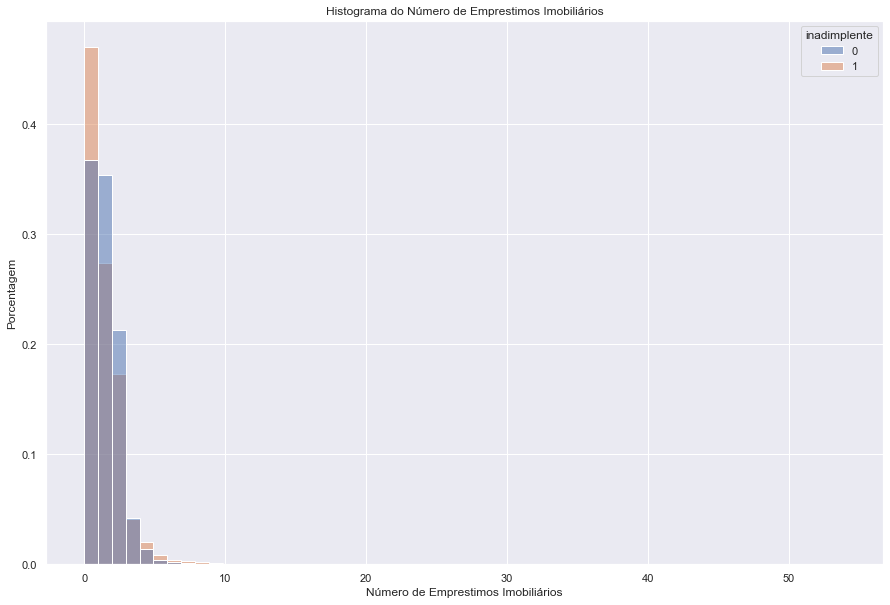

In [38]:
sns.histplot(data=df, x='numero_emprestimos_imobiliarios', hue='inadimplente', bins=55, 
             stat='probability', common_norm=False)

plt.title('Histograma do Número de Emprestimos Imobiliários')
plt.xlabel('Número de Emprestimos Imobiliários')
plt.ylabel('Porcentagem')
plt.show()

O histograma só serviu pra visualizar o que já foi dito anteriormente. A esmagadora maioria dos dados possuem 3 ou menos empréstimos imobiliários.

### *Outliers*

Chegando novamente na avaliação dos *outliers*, estes dados possuem um comportamento parecido com a variavel `numero_de_dependentes`, sendo a sua grande maioria parada na esquerda do gráfico. Sendo assim, todos os valores "um pouco" altos serão considerados outliers, o que pode ser ruim simplesmente retira-los pois a distribuição não é tão próxima da "normal".

In [39]:
outliers = df[(np.abs(stats.zscore(df['numero_emprestimos_imobiliarios'])) > 3)]

print('Quantidade de outliers (Z-Score):', outliers.shape[0])

Quantidade de outliers (Z-Score): 1081


Esta coluna acaba possuindo uma grande quantidade de outliers utilizando o método de *Z-Score* maior que 3. Veremos como estão distribuidos esses *outliers* em **inadimplente** e **não inadimplente**.

In [40]:
outliers['inadimplente'].value_counts()

0    918
1    163
Name: inadimplente, dtype: int64

Como explicado anteriormente, a quantidade de **inadimplentes** é bem menor que a quantidade de **não inadimplentes** mas em um conjunto tão desbalanceado e com poucos dados positivos, talvez seja necessário trabalhar com um processamento desta informação do que simplesmente retira-la do dataset.

Com esta informação em mente, não veremos a quantidade de *outliers* utilizando o método de IQR, pois é desnecessário.

## Variável: `numero_vezes_passou_90_dias`

Esta variável indica o número de vezes que o tomador passou mais de 90 dias em atraso.

### Valores `NaNs`

In [41]:
verifica_nans('numero_vezes_passou_90_dias')

Verificando a coluna numero_vezes_passou_90_dias
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


Novamente, mais uma coluna sem dados nulos. Podemos seguir para análise da sua distribuição.

### Distribuição

In [42]:
df['numero_vezes_passou_90_dias'].describe()

count   110,000.00
mean          0.27
std           4.22
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          98.00
Name: numero_vezes_passou_90_dias, dtype: float64

Essa distribuição parece seguir a mesma lógica das colunas anteriores, estando sua grande maioria para "esquerda", mas de uma maneira mais expressiva, pois pelo menos $3/4$ dos dados são totalmente zerados. Vamos ver se este comportamento segue vendo os dados divididos em **inadimplentes** e **não inadimplentes**.

In [43]:
df.groupby('inadimplente')['numero_vezes_passou_90_dias'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",0.14,2.97,0.00,0.00,0.00,0.00,98.00
1,"7,331.00",2.10,11.84,0.00,0.00,0.00,1.00,98.00


Aqui ocorreu uma diferença entre as outras colunas, os 2 grupos possuem o mesmo valor máximo. Além disso, podemos ver que os **inadimplentes** começam a ter valores maior que zero **ANTES** dos **não inadimplentes**. Avaliando desta maneira, este pode ser um indicação se é ou não **inadimplente**, mas só saberemos isso com maior certeza na etapa de avaliação dos modelos.

Para ter uma melhor noção deste conjunto, vamos avaliar novamente o topo do conjunto para ver como se varia.

In [44]:
q3 = df['numero_vezes_passou_90_dias'].quantile(.75)

check_df = df[df['numero_vezes_passou_90_dias'] > q3]
check_df['numero_vezes_passou_90_dias'].describe()

count   6,164.00
mean        4.82
std        17.19
min         1.00
25%         1.00
50%         1.00
75%         2.00
max        98.00
Name: numero_vezes_passou_90_dias, dtype: float64

Boa parte dos dados é Zero, como vimos pela distribuição geral... mas mesmo pegando o terceiro quartial, a variação segue sendo bem pequena, onde a grande maioria não passa do valor 2.

Para não haver dúvidas, vamos avaliar a quantidade de cada um dos valores encontrados.

In [45]:
df['numero_vezes_passou_90_dias'].value_counts()

0     103836
1       3886
2       1160
3        486
4        204
98       198
5        103
6         58
7         21
8         16
9         15
10         6
96         4
11         2
13         2
14         1
15         1
17         1
Name: numero_vezes_passou_90_dias, dtype: int64

Quase todos os registros estão com valor zero e o restante tem a sua maioria com valores 1 e 2. Como a distribuição dos valores em **inadimplentes** era um pouco diferente, vejamos como é a quantidade dos valores apenas nesse grupo.

In [46]:
df.query("inadimplente == 1")['numero_vezes_passou_90_dias'].value_counts()

0     4801
1     1304
2      552
3      273
4      145
98     105
5       66
6       34
7       18
9       12
8       12
96       4
10       3
11       1
17       1
Name: numero_vezes_passou_90_dias, dtype: int64

Como **inadimplente** possui um valor bem menor que os **não inadimplentes**, esta indicação de ter um valor maior que zero parece ser uma indicação interessante. Será visto com mais cautela durante a etapa de **Processamento de Dados**.

Para se ter uma visão melhor desta distribuição, podemos verificar o seu histograma.

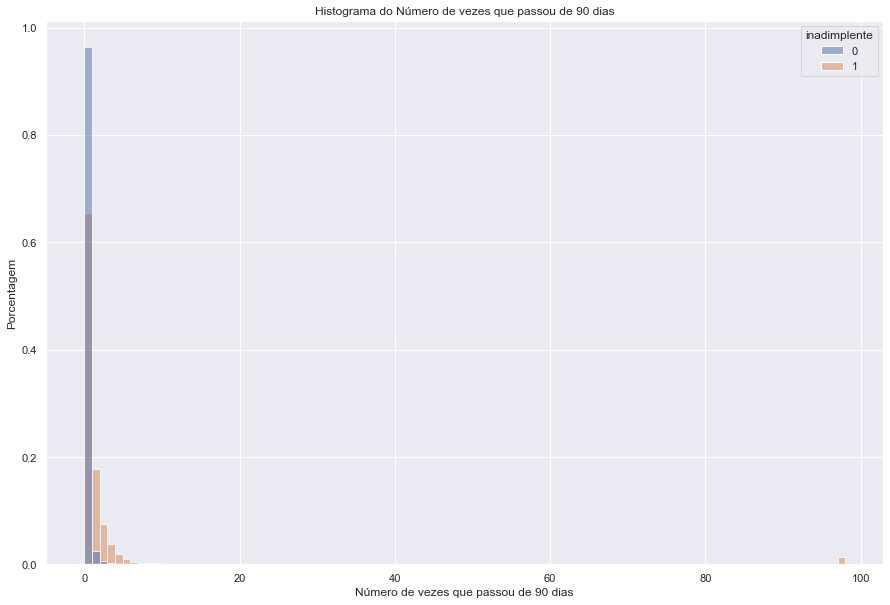

In [47]:
sns.histplot(data=df, x='numero_vezes_passou_90_dias', hue='inadimplente', bins=99, 
             stat='probability', common_norm=False)

plt.title('Histograma do Número de vezes que passou de 90 dias')
plt.xlabel('Número de vezes que passou de 90 dias')
plt.ylabel('Porcentagem')
plt.show()

Como visto anteriormente, quando os valores são diferentes de 0, a maioria deles acaba se tornando **inadimplentes**. Esta é uma informação valiosa e podemos usar ao nosso favor para tentar resolver o problema de predição. 

E como estes dados estão em sua esmagadora maioria a esquerda do gráfico, não iremos avaliar os *outliers*, pois quase todos os valores diferentes de zero serão considerados (e por quê a distribuição não se assemelha a normal).

## Variável: `util_linhas_inseguras`

Esta variável indica quanto que o cliente está usando, relativamente ao limite dele, de linhas de crédito que não são seguradas por qualquer bem do tomador e.g: imoveis, carros etc

### Valores `NaNs`

In [48]:
verifica_nans('util_linhas_inseguras')

Verificando a coluna util_linhas_inseguras
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


Novamente, nenhum valor nulo. Podemos seguir para próxima seção.

### Distribuição

In [49]:
df['util_linhas_inseguras'].describe()

count   110,000.00
mean          5.93
std         252.30
min           0.00
25%           0.03
50%           0.16
75%           0.56
max      50,708.00
Name: util_linhas_inseguras, dtype: float64

Esta distribuição segue um comportamento parecido com as anteriores que tinham a grande quantidade dos valores em zero. A diferença neste exemplo é que possui valores em formato `float` e por isso, possui números com vírgula. Analisando sua distribuição, $75\%$ dos dados possuem valores entre $[0;0.56]$ mas o que chama a atenção é o valor de $50708$, pois é muito maior que o restante. Como feito anteriormente, será verificado a distribuição dos valores em **inadimplente** e **não inadimplente**.

In [50]:
df.groupby('inadimplente')['util_linhas_inseguras'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",6.15,260.30,0.00,0.03,0.13,0.49,"50,708.00"
1,"7,331.00",2.85,78.74,0.00,0.40,0.84,1.00,"3,629.00"


Analisando as duas distribuições, parece que a maioria dos dados transitam entre os valores de 0 e 1. Mas como podemos ver, existe valor muito a cima deste intervalo, e por isso, precisamos verificar se isso é proposital ou pode ser algum erro nos dados. Para isso, veremos quantos dados possuem valor **MAIOR** que 1.

In [51]:
df[df['util_linhas_inseguras'] > 1.0]['util_linhas_inseguras'].describe()

count    2,452.00
mean       252.65
std      1,671.69
min          1.00
25%          1.02
50%          1.07
75%          1.30
max     50,708.00
Name: util_linhas_inseguras, dtype: float64

Existem $2452$ valores a cima de 1,0 na coluna, e avaliando sua distribuição, $75\%$ deste conjunto não passa de 1,3. Vamos verificar a quantidade de **inadimplentes** e **não inadimplentes** neste grupo de valores.

In [52]:
df[df['util_linhas_inseguras'] > 1.0]['inadimplente'].value_counts()

0    1555
1     897
Name: inadimplente, dtype: int64

Um pouco mais de $1/3$ dos dados são de **inadimplentes**, o que indica que tais dados tem um certo valor.

Para se ter uma maior certeza dessa distribuição, vamos avaliar os que possuem valores maior que 2.

In [53]:
df[df['util_linhas_inseguras'] > 2.0]['util_linhas_inseguras'].describe()

count      272.00
mean     2,268.43
std      4,548.36
min          2.00
25%          3.51
50%        833.50
75%      2,921.00
max     50,708.00
Name: util_linhas_inseguras, dtype: float64

Apenas 272 valores são maiores que 2 nesta coluna e os dados começam a variar bastante neste pequeno intervalo. Uma possível "solução" para este conjunto seria limitar os valores, onde tudo acima de 2 se "transforma" em 2. Assim não teremos com *outliers*.

E como os dados originais possuem uma grande variação, nem precisamos verificar a quantidade de *outliers*, pois não ganhariamos nenhuma informação interessante.

## Variável: `vezes_passou_de_30_59_dias`

Esta variável indica o número de vezes que o cliente atrasou, entre 30 e 59 dias, o pagamento de um empréstimo. Ela tem o mesmo propósito da variável `numero_vezes_passou_90_dias`, mas usando outro intevalo de tempo.

### Valores `NaNs`

In [54]:
verifica_nans('vezes_passou_de_30_59_dias')

Verificando a coluna vezes_passou_de_30_59_dias
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


Outra variável sem valores nulos.

### Distribuição

In [55]:
df['vezes_passou_de_30_59_dias'].describe()

count   110,000.00
mean          0.42
std           4.24
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          98.00
Name: vezes_passou_de_30_59_dias, dtype: float64

Como esta variável possui a mesma indicação de `numero_vezes_passou_90_dias` (apenas mudando o intervalo de tempo), ela possui uma distribuição bem parecida, mas esperado que tenha mais (ou a mesma quantidade) de valores maiores que zero, já que se trata de um intervalo que ocorre **ANTES** dos 90 dias. Veremos como a distribuição se comporta entre os grupos de **inadimplentes** e **não inadimplentes**.

In [56]:
df.groupby('inadimplente')['vezes_passou_de_30_59_dias'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",0.28,3.00,0.00,0.00,0.00,0.00,98.00
1,"7,331.00",2.40,11.81,0.00,0.00,0.00,2.00,98.00


Aqui já podemos ver uma diferença ao intervalo de 90 dias, pois o terceiro quartil já começa a ter valores a partir de 2 (enquanto no de 90 dias era de 1). Veremos como os dados são visualizados através do Histograma.

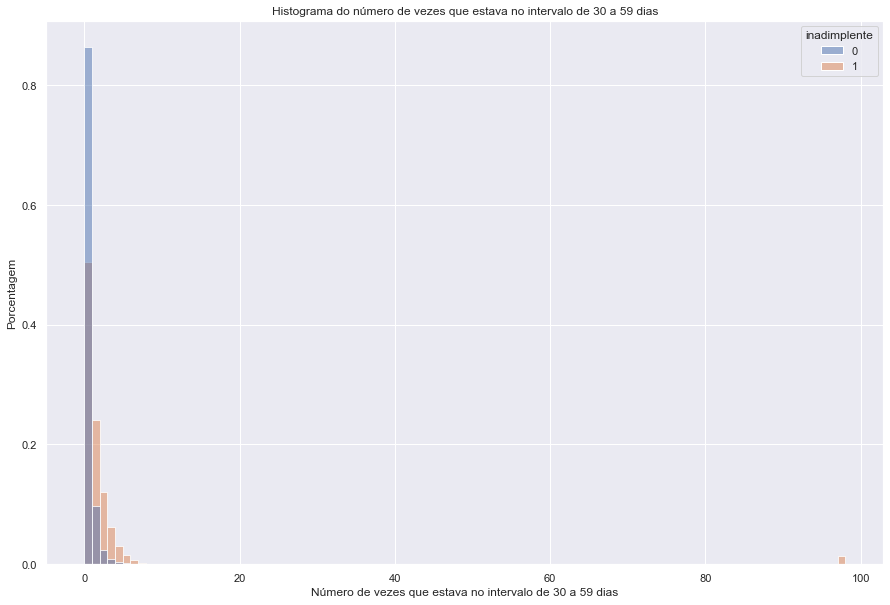

In [57]:
sns.histplot(data=df, x='vezes_passou_de_30_59_dias', hue='inadimplente', bins=99, 
             stat='probability', common_norm=False)

plt.title('Histograma do número de vezes que estava no intervalo de 30 a 59 dias')
plt.xlabel('Número de vezes que estava no intervalo de 30 a 59 dias')
plt.ylabel('Porcentagem')
plt.show()

Novamente, em comparação aos 90 dias, a partir do valor 1, a quantidade de **inadimplentes** passam os **não inadimplentes**, o que reforça mais ainda que esta pode ser uma variável com bastante potencial para fazer a divisão dos exemplos positivos dos negativos.

## Variável: `razao_debito`

Esta variável indica a razão entre as dívidas e o patrimônio do tomador.

### Valores `NaNs`

In [58]:
verifica_nans('razao_debito')

Verificando a coluna razao_debito
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


Outra coluna sem valores nulos.

### Distribuição

In [59]:
df['razao_debito'].describe()

count   110,000.00
mean        354.82
std       2,074.14
min           0.00
25%           0.18
50%           0.37
75%           0.87
max     329,664.00
Name: razao_debito, dtype: float64

A distribuição dessa variável lembra um pouco a `util_linhas_inseguras`, só que possuindo uma distribuição percorrendo mais pelos valores do intervalo de 0 e 1. Para se ter uma melhor noção, veremos a distribuição entre os grupos positivo e negativo.

In [60]:
df.groupby('inadimplente')['razao_debito'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",358.44,"2,119.32",0.00,0.17,0.36,0.86,"329,664.00"
1,"7,331.00",304.11,"1,283.13",0.00,0.19,0.43,0.90,"38,793.00"


Neste caso, avaliando os pontos das distribuições (sem contar o máximo), elas são bem parecidas, tendo pouca diferença. O valor máximo bem maior em **não inadimplente** faz o desvio ser maior que no caso positivo. Assim como foi feito com `util_linhas_inseguras`, vamos avaliar os valores maiores que 1.

In [61]:
df[df['razao_debito'] > 1.0]['razao_debito'].describe()

count    25,745.00
mean      1,515.05
std       4,077.29
min           1.00
25%          42.00
50%         903.00
75%       2,224.00
max     329,664.00
Name: razao_debito, dtype: float64

Aqui podemos ver a diferença em comparação ao `util_linhas_inseguras`, pois os valores acima de 1 possuem uma grande quantidade (acima de 25000 valores) e sua distribuição já começa a subir rapidamente. Veremos a quantidade de exemplos entre os dados positivos e negativos.

In [62]:
df[df['razao_debito'] > 1.0]['inadimplente'].value_counts()

0    24055
1     1690
Name: inadimplente, dtype: int64

A quantidade de **inadimplentes** com razão debito maior que 1 equivale a $23\%$ do total. Esta é uma quantidade considerável, principalmente observando que existem poucos exemplos positivos. Na etapa de **processamento de dados**, será necessário ter uma certa atenção com este dado, devido a sua alta variância (e muitos *outliers*).

## Variável: `numero_linhas_crdto_aberto`

Esta variável indica o número de empréstimos em aberto pelo cliente.

### Valores `NaNs`

In [63]:
verifica_nans('numero_linhas_crdto_aberto')

Verificando a coluna numero_linhas_crdto_aberto
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


Mais uma vez, nenhum valor nulo encontrado.

### Distribuição

In [64]:
df['numero_linhas_crdto_aberto'].describe()

count   110,000.00
mean          8.45
std           5.14
min           0.00
25%           5.00
50%           8.00
75%          11.00
max          58.00
Name: numero_linhas_crdto_aberto, dtype: float64

Esta distribuição possui um comportamento mais próximo da distribuição normal, tendo uma variação visivel entre os quartis. Além disso, a média e mediana possui valores bem próximos, o que também é uma ótima indicação. Veremos sua distribuição divindo entre **inadimplentes** e **não inadimplentes**.

In [65]:
df.groupby('inadimplente')['numero_linhas_crdto_aberto'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",8.49,5.10,0.00,5.00,8.00,11.00,58.00
1,"7,331.00",7.88,5.66,0.00,4.00,7.00,11.00,52.00


A distribuição dos dois grupos possuem um comportamento bem próximo e ambos tem o dado máximo (*outlier*) com valores parecidos. Veremos como a distribuição se comporta através do Histograma.

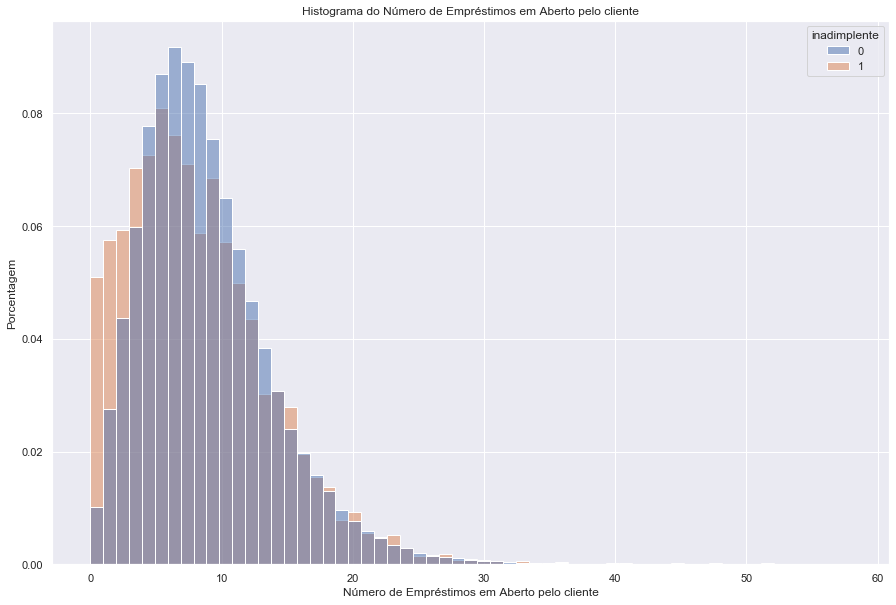

In [66]:
sns.histplot(data=df, x='numero_linhas_crdto_aberto', hue='inadimplente', bins=59, 
             stat='probability', common_norm=False)

plt.title('Histograma do Número de Empréstimos em Aberto pelo cliente')
plt.xlabel('Número de Empréstimos em Aberto pelo cliente')
plt.ylabel('Porcentagem')
plt.show()

Analisando o gráfico, é possível ver que entre 0 e 3 emprestimos abertos, o cliente tem mais chance de ser **inadimplente**. Entre 4 e 13, o comportamento se inverte, tendo mais chance de ser **não inadimplente**. Em valores a cima disso, possui uma chance pequena e bem próxima entre os 2 grupos.

### *Outliers*

Com a distribuição mais concentrada do lado esquerdo, é esperado que os valores *outliers* sejam os mais altos do conjunto (ainda mais com uma média próxima de 8 e desvio padrão próximo de 5).

Então, primeiramente veremos os outliers através do cálculo do *Z-Score* maior que 3.

In [67]:
outliers = df[(np.abs(stats.zscore(df['numero_linhas_crdto_aberto'])) > 3)]

print('Quantidade de outliers (Z-Score):', outliers.shape[0])

Quantidade de outliers (Z-Score): 1346


Nesta técnica, a quantidade de valores encontrados é bastante alta. Veremos como esses outliers estão divididos entre as classes positivas e negativas.

In [68]:
outliers['inadimplente'].value_counts()

0    1249
1      97
Name: inadimplente, dtype: int64

A grande maioria é exemplos negativos. Em um conjunto com uma grande quantidade exemplos **não inadimplentes**, talvez não seja de todo ruim retirar os outliers deste caso.

Veremos como os outliers são visualizados através do gráfico de caixa.

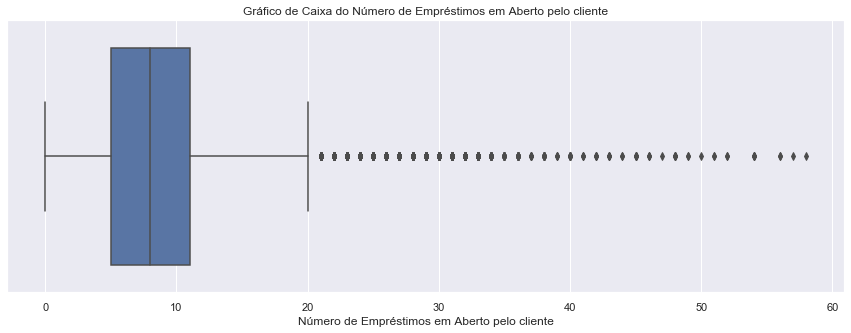

In [69]:
plt.figure(figsize=(15,5))
sns.boxplot(data=df, x='numero_linhas_crdto_aberto')

plt.title('Gráfico de Caixa do Número de Empréstimos em Aberto pelo cliente')
plt.xlabel('Número de Empréstimos em Aberto pelo cliente')
plt.show()

Como foi explicado no inicio da seção, todos os outliers estão acima do limite superior, variando de 20 até 58. Só por informação, veremos a quantidade de *outliers* utilizando o método de IQR.

In [70]:
outliers_iqr('numero_linhas_crdto_aberto')

Quantidade de Outliers (IQR): 2911


## Variável: `numero_de_vezes_que_passou_60_89_dias`

Esta variável indica o número de vezes que o cliente atrasou, entre 60 e 89 dias, o pagamento de um empréstimo. Novamente, esta variável tem o mesmo principio dos intervalos de 30 a 59 dias, e acima de 90 dias.

### Valores `NaNs`

In [71]:
verifica_nans('numero_de_vezes_que_passou_60_89_dias')

Verificando a coluna numero_de_vezes_que_passou_60_89_dias
Quantidade de valores nulos: 0 [0.00%]
Quantidade de valores nulos (inadimplente): 0 [0.00%]
Quantidade de valores nulos (não inadimplente): 0 [0.00%]


Ultima coluna a ser verificada e não possui valores nulos. Então, iremos para distribuição.

### Distribuição

In [72]:
df['numero_de_vezes_que_passou_60_89_dias'].describe()

count   110,000.00
mean          0.24
std           4.20
min           0.00
25%           0.00
50%           0.00
75%           0.00
max          98.00
Name: numero_de_vezes_que_passou_60_89_dias, dtype: float64

E novamente, a distribuição dos dados está praticamente igual as outras colunas (que possuem o intervalo de tempo diferente). Para não ter explicações repetidas, vamos conferir a distribuição entre **inadimplentes** e **não inadimplentes*.

In [73]:
df.groupby('inadimplente')['numero_de_vezes_que_passou_60_89_dias'].describe()

,count,mean,std,min,25%,50%,75%,max
inadimplente,,,,,,,,
0,"102,669.00",0.13,2.96,0.00,0.00,0.00,0.00,98.00
1,"7,331.00",1.84,11.83,0.00,0.00,0.00,1.00,98.00


Assim como antes, a distribuição está bem próxima das colunas anteriores, mas mais próximo da de 90 dias. Veremos como fica a visualização dados através do Histograma.

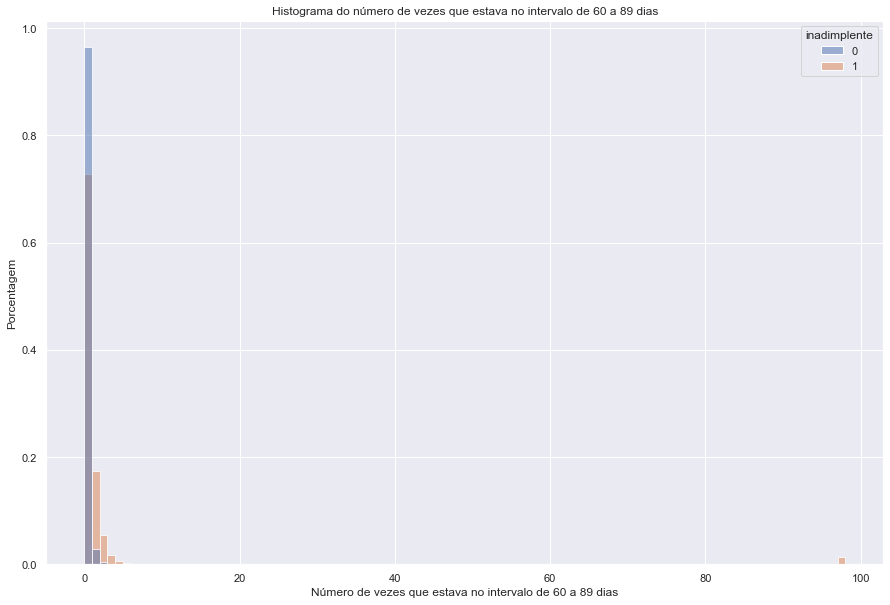

In [74]:
sns.histplot(data=df, x='numero_de_vezes_que_passou_60_89_dias', hue='inadimplente', bins=99, 
             stat='probability', common_norm=False)

plt.title('Histograma do número de vezes que estava no intervalo de 60 a 89 dias')
plt.xlabel('Número de vezes que estava no intervalo de 60 a 89 dias')
plt.ylabel('Porcentagem')
plt.show()

E assim como as outras 2 colunas, a partir dos valores a cima de zero, a possibilidade de ser **inadimplente** é maior. Com isso em mente, é bem possível que a utilização destas 3 colunas sejam de grande auxílio na solução do problema.

# Conclusão

Após análise geral dos dados e as informações retiradas de cada uma das variáveis, é possível organizar *insights* adquiridos:

## Dados não balanceados

Através da análise inicial, foi observado que os dados **não são** balanceados. Isto significa que o modelo pode ter dificuldade no aprendizado da informação. Para ser mais exato, o dataset possuí um total de $110.000$ linhas com a a coluna a ser predita tendo apenas 2 valores possíveis: **inadimplente (1)** ou **não (0)**. A informação está preenchida de tal maneira:

| Inadimplente? | Quantidade | Porcentagem |
| - | -: | -: |
| **Não** | $102.669$ | $93,34\%$ |
| **Sim** | $7.331$ | $6,66\%$ |

## Idade

A variável `idade` **não possuí** valores faltantes e seus dados estão bem distribuídos. Ela possuí apenas $36$ *outliers*, o que não faria grande falta se retirasse esses dados do *dataset*. Além disso, uma possível modificação deste dado seria o agrupamento por faixa-etaria.

## Número de dependentes

A variável `numero_de_dependentes` **possui** $2.878$ valores faltantes, sendo eles distribuídos da seguinte maneira:

| Grupo | Quantidade | Porcentagem sobre o grupo |
| - | -: | -: |
| **Inadimplente** | $132$ | $1,80\%$ |
| **Não Inadimplente** | $2.746$ | $2,67 \%$ |
| **Total** | $2.878$ | $2,62\%$ |

Como essas quantidades são pequenas, podemos preencher com elas com o valor $0$, que neste caso estamos apenas dizendo: *O não preenchimento de depentes, significa que não tem dependentes.*

Além disso, nesta coluna começamos a encontrar bastante valores *outliers*, seja pelo método *Z-Score* (739) ou *IQR* (9748). Como se trata de uma grande quantidade de valores, podendo perder informação importante, a solução que será aplicada é a inserção dos dados em grupos. Exemplificado:

| Quantidade | Grupo |
| - | - |
| 0 | Sem dependentes |
| 1 | Um dependente |
| 2 | Dois dependentes |
| 3,4 | Três a Quatro dependentes |
| 4+ | 5 ou mais dependentes |

*Estes grupos não estão totalmente definidos e podem ser modificados na etapa de* *__Processamento de Dados__.*

## Salário Mensal

A variável `salario_mensal` **possui** $21.763$ valores faltantes, sendo eles distribuídos da seguinte maneira:

| Grupo | Quantidade | Porcentagem sobre o grupo |
| - | -: | -: |
| **Inadimplente** | $1.247$ | $17,01\%$ |
| **Não Inadimplente** | $20.516$ | $19,98 \%$ |
| **Total** | $21.763$ | $19.78\%$ |

As quantidades de valores nulos são bem **consideráveis** para esta coluna, podendo perder $1/5$ dos dados em caso de retirada dessas informações. A não adição do salário pode ser resolvida adicionando o valor $0$, que neste caso significa que: *O não preenchimento do salário, significa que não tem salário*. Entretanto, isto pode ser "contornado" pela solução explicada a seguir.

Ao analisar a quantidade de *outliers* e sua distribuição, notamos que existe valores muito maiores que o restante, fazendo a média e o desvio padrão dos dados aumentarem bastante. Sendo assim, uma possível solução trataria de organizar os dados em grupos. Exemplificando: 

* **Grupo 1**: Sem salário ou não informado
* **Grupo 2**: Até 2 Salários mínimos
* **Grupo 3**: Até 4 Salários mínimos
* *...*

_Estes grupos não foram especificados e serão definidos durante a etapa de **Processamento de Dados**._

## Quantidade de Empréstimos Imobiliários

A variável `numero_emprestimos_imobiliarios` **não possui** valores faltantes e seus dados não são muito bem distribuídos, tendo a grande maioria dos dados com valores entre $0$ e $1$. Como o seu valor máximo é $20$ e tendo poucos valores a partir de 3, uma boa ideia seria o agrupamento das quantidades em grupos, como:

* **Grupo 1**: Sem empréstimos
* **Grupo 2**: Um empréstimo
* **Grupo 3**: Dois empréstimos
* **Grupo 4**: Três ou mais empréstimos

_Estes grupos não foram especificados e serão definidos durante a etapa de **Processamento de Dados**._

## Linhas de crédito inseguras relativas ao seu limite

A variável `util_linhas_inseguras` **não possui** valores faltantes e seus dados não são muito bem distribuídos, pois a grande maioria dos seus dados se encontrados no intervalo real de $0$ até $1$, mas possuindo o valor máximo de $50.708$. $2452$ valores são maiores que $1$ e apenas $272$ são maiores que $2$. Uma possível solução para retirar os dados discrepantes deste conjunto seria limitar os seus valores, onde se seu valor for maior que $2$, ele é modificado para $2$.

_Estes valores a serem modificados não foram especificados e serão definidos durante a etapa de **Processamento de Dados**._

## Razão entre as dívidas e o patrimônio 

A variável `razao_debito` **não possui** valores faltantes e seus dados não são muito bem distribuídos, tendo a grande maioria dos seus dados no intervalo real de $0$ até $1$, mas possuindo o valor máximo de $329.664$. Entretanto, $23\%$ dos dados são maiores do que $1$ e possuindo diversos valores até chegar ao seu máximo. Neste caso, adicionar um limite como `util_linhas_inseguras` **pode não ser** a melhor alternativa. **Esta é uma das colunas para ter bastante atenção durante a etapa de Processamento de Dados, pois os valores maiores que 1 contém uma grande parcela dos Inadimplentes**.

## Número de Empréstimos Aberto

A variável `numero_linhas_crdto_aberto` **não possui** valores faltantes e seus dados estão melhores distribuídos que os demais, tendo grande parte da seus valores entre $0$ e $11$, e possuindo o valor máximo de $58$. Avaliando seu comportamento através do histograma, foi verificado que dependendo da quantidade, ocorre uma **inversão de probabilidade** de ser **Inadimplente ou não**. 

Foi encontrado $1.346$ *outliers* através do método de *Z-Score* e $2.911$ utilizando o *IQR*. Com esta grande quantidade de *outliers*, pode não ser uma boa a eliminação de tais valores **MAS** ao verificar a distribuição, foi notado apenas $97$ como **inadimplentes**. Como a quantidade de exemplos negativos é bem grande, a eliminação deles pode não ter um grande impacto no treinamento dos modelos. 

## Número de vezes que o cliente atrasou o pagamento de um empréstimo

Esta informação está inserida em 3 colunas diferentes, apenas mudando o intervalo de tempo referente ao atraso. As variáveis são as seguintes:

* **`vezes_passou_de_30_59_dias`** - Intervalo entre 30 e 59 dias
* **`numero_de_vezes_que_passou_60_89_dias`** - Intervalo entre 60 e 89 dias
* **`numero_vezes_passou_90_dias`** - Intervalo maior que 90 dias

Todas as colunas **não possuem** dados faltantes, tendo suas distribuições bem parecidas. A esmagadora maioria dos dados não possuem $0$ atrasos, tendo o seus máximos em $98$. Como a maioria está zerada e todas as outras quantidades possuem mais registros de **inadimplentes**, o que já em si é um bom indicativo.

Para tratar os dados *outliers* destas colunas, será feita a modificação de quantidade para um registro `Booleano`. Neste sentido, as colunas irão apenas funcionar com o princípio de: _**JÁ ATRASOU OU NÃO** o pagamento de um empréstimo._